# Test examples of ligand dissociation trajectories using IFPs

    1. Computing interaction fingerprints (IFP) for
        -- a single structure prepared for MD simulations (HSP90; PDB ID 6EI5, dcd format)
        -- a trajectory (for selected frames; dcd format)
        -- PDB structure
    2. Visualizing protein residues that are involved in protein-ligand interactions, including water-bridges
     

### v 1.0

    Copyright (c) 2020
    Released under the GNU Public Licence, v2 or any higher version
    
### Author: Daria Kokh
    Daria.Kokh@h-its.org
    Heidelberg Institute of Theoretical Studies (HITS, www.h-its.org)
    Schloss-Wolfsbrunnenweg 35
    69118 Heidelberg, Germany
    

### Input data required:
    Data can be doenloaded from https://zenodo.org/record/3755337#.XrF-iGgzaUk
    MD trajectory file of a complex
    pdb file of a complex (for example, generated from the first frame)
    pdb and mol2 file of a ligand separately 
    
    
### Packages required:
    numpy
    matplotlib
    MDAnalysis v. 20.1
    pandas
    seaborn
    RDkit
    code is written on Python 3.x and tested on the version 3.7

In [25]:
#from SetUp.trajectory_analysis import *
import warnings
warnings.filterwarnings("ignore")

#%load_ext autoreload
#%autoreload 2

########################################################################

MDAnalysis must be uploaded from developer version see

https://github.com/MDAnalysis/mdanalysis/wiki/DevelopmentBranch

#########################################################################

1. IFP
Variables:
Functions:


    IFP_list(property_list, sel_ligands)
    make_IFT_table(IFP_prop_list,snaps)
    IFP(u_mem,sel_ligands,property_list,WB_analysis = True,ligand_radius =0)
    table_combine (df_HB,df_WB,df_prop,ligand_name,residues_name = [],start=0,stop=None,step=1)
    read_IFP(list_IFP)
    Plot_IFP(df,contact_collection=None

######################################################################### 

In [26]:
import glob, os
import sys
import subprocess
import numpy as np

import pandas as pd
from pandas import ExcelFile 

from matplotlib import *
from matplotlib import cm
import matplotlib.ticker
from matplotlib import gridspec
import  pylab as plt
import seaborn
import seaborn as sns


from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import EState
from rdkit.Chem import MolDb
from rdkit.Chem import QED
from rdkit.Chem import rdchem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import MDAnalysis as mda
from MDAnalysis.lib.formats.libdcd import DCDFile
from MDAnalysis.analysis import contacts,align,rms
from MDAnalysis.analysis.base import AnalysisFromFunction
from MDAnalysis.coordinates.memory import MemoryReader
import MDAnalysis.analysis.hbonds as hb

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.cluster import KMeans
from matplotlib import gridspec

from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy as clust
from scipy.spatial.distance import pdist

In [27]:
from Scripts.Clustering import *

#  I. Preprocessing
###  1. Read IFP data for one compound

In [28]:

ligand =  "SAD_3"   
name_template = ligand+"*RAMD-03-2020.pkl"
dir_all =  "DATA\\HSP90\\"
DIR_in = dir_all + ligand + "\\"

if DIR_in.find("*") < 0:
    DIR_out =  DIR_in
else:
    DIR_out = dir_all


##################################################
# readIFP database for just one ligand
####################################################

#---- read IFP data set
df_tot_org,ligandsi,new_list_col = read_databases(DIR_in,name_template)
print(df_tot_org.shape)    
#----- remove IFP that appear rarely (in less then threshold from the total number of frames in each trajectory)
df_tot_new = clean_ramd(df_tot_org,threshold = -1)
df_tot_org= df_tot_new
#---- sort resudues by number
resi_list_sorted,resi_name_list_sorted,ifp_list = separate_IFP(df_tot_org.columns.tolist())
# if Replicas are not included in the database, but should be, we will fill out Repl column
try:
    if(np.unique(df_tot_org.Repl.values) == ''):
        Repl = []
        R = 0
        start = np.argwhere(df_tot_org.time.values == 0).flatten()
        for i in range(0,df_tot_org.shape[0]): 
            if i in start: R += 1
            Repl.append("Repl_"+str(R))
        df_tot_org.Repl = Repl
except:
    pass

DATA\HSP90\SAD_3\SAD_3-RAMD-03-2020.pkl SAD_3-RA
(14638, 279)
(14638, 279) (14638, 279)
Auxi_0 - skip no-IFP property
Auxi_1 - skip no-IFP property
COM - skip no-IFP property
RGyr - skip no-IFP property
RMSDl - skip no-IFP property
RMSDp - skip no-IFP property
Repl - skip no-IFP property
Traj - skip no-IFP property
WAT - skip no-IFP property
length - skip no-IFP property
ligand - skip no-IFP property
time - skip no-IFP property
COM_x - skip no-IFP property
COM_y - skip no-IFP property
COM_z - skip no-IFP property


### 2.Check ligand RMSD and discard trajectories where ligand readily left the pocket at the beginning of the trajectory part used for generation IFPs 

(28,)
too large RMSD in the start :  8.670201585607627 24.594205724677636
too small RMSD at the end:  1.3551995521095586 1.4898367948279851
too small RMSD at the end:  1.6306509197847048 0.6554051980171854
too large RMSD in the start :  5.362232891799929 24.528091426171052
too large RMSD in the start :  9.931100792904232 26.472651665701985
too small RMSD at the end:  1.585890477574776 1.3664690480250565
too small RMSD at the end:  1.6063444365657313 1.8006977837402889
too large RMSD in the start :  8.676842588689055 26.060991282471196
too small RMSD at the end:  1.0723907709939406 1.0655547823938798
too large RMSD in the start :  7.013975574064397 23.86909358549179
too small RMSD at the end:  1.6844538467204577 1.2379021436392146
too large RMSD in the start :  5.7272699780945775 26.515776127566145


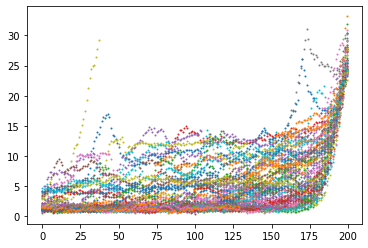

Traj to be discarded:  12
Original size:  (14638, 279)  trajectories: 74
Final size:  (12238, 279)


In [29]:
print(np.unique(df_tot_org.Traj.values.astype(int)).shape)
threshold_start_RMSD = 5
threshold_end_RMSD = 15

trj_to_discard = []
tot_traj = 0
k = 0
for j in np.unique(df_tot_org.Repl.values):
    df_tot_Repl = df_tot_org[df_tot_org.Repl == j]
    for i in np.unique(df_tot_Repl.Traj.values.astype(int)):
        df_tot_Repl_Traj = df_tot_Repl[df_tot_Repl.Traj == str(i)]
        if(df_tot_Repl_Traj.RMSDl.values[0] > threshold_start_RMSD) :
            trj_to_discard.append((j,i))
            print("too large RMSD in the start : ",df_tot_Repl_Traj.RMSDl.values[0],df_tot_Repl_Traj.RMSDl.values[-1])
        elif (df_tot_Repl_Traj.RMSDl.values[-1] < threshold_end_RMSD) :  
            trj_to_discard.append((j,i))
            print("too small RMSD at the end: ",df_tot_Repl_Traj.RMSDl.values[0],df_tot_Repl_Traj.RMSDl.values[-1])
        else:
            plt.plot(df_tot_Repl_Traj.RMSDl,marker='o', linestyle="",markersize=1)
            tot_traj +=1
#        print(df_tot_Repl_Traj.COM_z.max(),df_tot_Repl_Traj[df_tot_Repl_Traj.time == 0].COM_z.values[0])
plt.show()
print("Traj to be discarded: ", len(trj_to_discard))
print("Original size: ",df_tot_org.shape," trajectories:",df_tot_org[df_tot_org.time == 0].shape[0])
for j,i in trj_to_discard:
#    print("To discard:",i,j)
    df_tot_org = df_tot_org[~((df_tot_org.Traj == str(i)) & (df_tot_org.Repl == j))]
print("Final size: ",df_tot_org.shape)

Plot IFPs

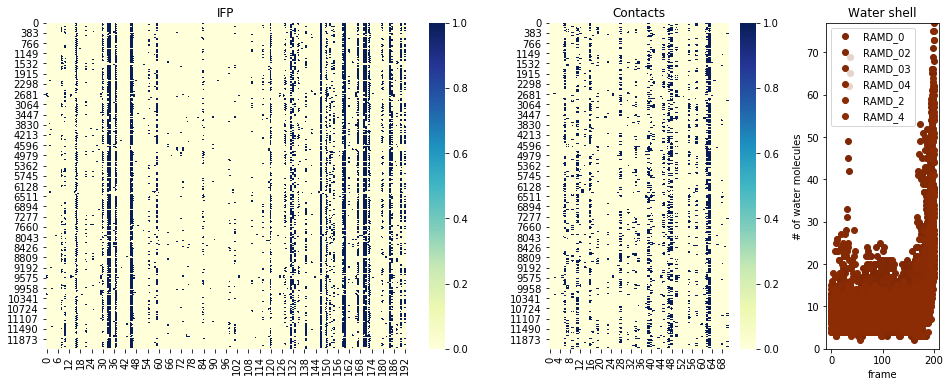

In [30]:
Plot_IFP(df_tot_org)

###   3. Change residue numbering 

Text(0.5, 1, 'IFP')

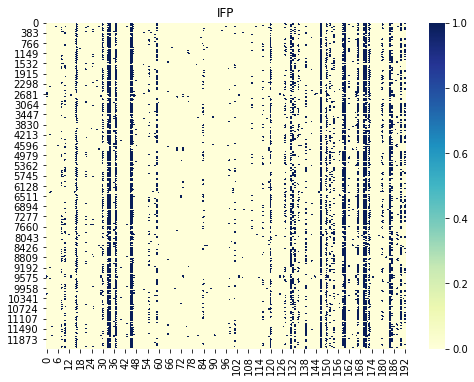

In [7]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[4, 2, 1]) 
ax = plt.subplot(gs[0])
ifp_list = ["HY","AR","HD","HA","HL","IP","IN","WB","LIP"]
columns_IFP = []  # standard IFP
columns_CONT = []  # just contacts
for c in df_tot_org.columns.tolist():
        if c[0:2] in ifp_list:
            columns_IFP.append(c)
        elif c[0:2]  == "RE":
            columns_CONT.append(c)
ax =  plt.subplot(gs[0])
ax.set_title('IFP')
df1 = df_tot_org[columns_IFP].values
xticklabels = np.asarray(columns_IFP)
sns.heatmap(np.float32(df1), cmap="YlGnBu")
ax.set_title('IFP')


In [31]:
# --- Select IFP only-
ifp_list = ["AR","HD","HA","HY","WB","IP","IN","WB"]
shift = 0
if HSP90:   shift = 16 # for HSP90
columns_IFP = []
columns_IFP_renamed = {}
for c in df_tot_org.columns.values:
    if c[0:2] in ifp_list:   
        columns_IFP.append(c[:6]+str(int(c[6:])+shift))
        columns_IFP_renamed.update( {c : c[:6]+str(int(c[6:])+shift)} )
df_tot = df_tot_org.rename(columns_IFP_renamed, axis='columns')


## 4. Remove rare contacts

In [32]:
unpickled_df=df_tot        

# remove rare contacts
df_ext = unpickled_df[columns_IFP]        
print("Original ", df_ext.shape)
columns_IFP_reduced = np.asarray(columns_IFP)[df_ext.sum().values > 0]
df_ext = df_ext[columns_IFP_reduced]   
columns_IFP = columns_IFP_reduced
print("Reduced", df_ext.shape)
        
X = df_ext.values
print(X.shape)
add_columns = ["Repl","ligand","Traj","RMSDl","time","length","WAT","RGyr","COM_x","COM_y","COM_z","COM"]
df_ext[add_columns] = unpickled_df[add_columns]

Original  (12238, 193)
Reduced (12238, 191)
(12238, 191)


# II. Clustering of all snapshots

## 1. Evaluate clastering performance for different number of clusters

In [33]:
# Here we can 
%load_ext autoreload
%autoreload 2


Evaluate_cluster_k = False
if Evaluate_cluster_k:
    from sklearn.metrics import silhouette_score
    Sum_of_squared_distances = []
    sil = []
    K = range(3,18)
    for k in K:
        km = KMeans(n_clusters=k, random_state=0).fit(X)
        Sum_of_squared_distances.append(km.inertia_)
        sil.append(silhouette_score(X, km.labels_, metric = 'euclidean'))                
    
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    plt.plot(K, sil, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
    plt.title('Silhouette Method For Optimal k')
    plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Cluster all snapshots by IFP using kmeans (or kmodes) 

In [34]:
kmodes = False
Frame_clusters = 8
if kmodes:
    from kmodes.kmodes import KModes
    km = KModes(n_clusters=Frame_clusters, init='Huang', n_init=2, verbose=1)
    clusters = km.fit_predict(X) 
else:
    km = KMeans(n_clusters=Frame_clusters, random_state=0).fit(X)
    labels_list = np.unique(km.labels_)
    
df_ext["label"] = km.labels_
print(df_ext.shape,X.shape)


(12238, 204) (12238, 191)


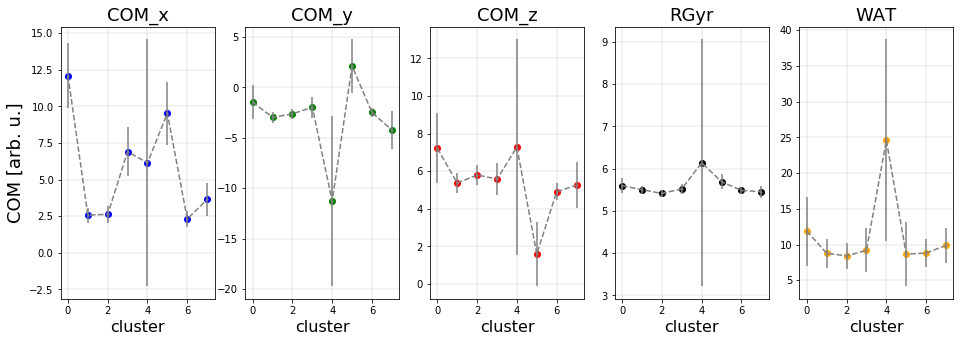

In [35]:
#  distribution of the average ligand COM and the numer of water molecyles in the water shell in clusters
Plot_COM(df_ext)

##   3. Visuzalize dissociation trajectories in a graph representation

STD:  0 2.2071721176295442 1.6881350536183832 1.8546110973682575 2.2703936833396114
STD:  1 0.5147340152755395 0.5321098501321059 0.5373233488209768 0.35275761002713446
STD:  2 0.5851198929472514 0.4965300150727883 0.5399346187870171 0.4514533336701127
STD:  3 1.6990882062082435 1.0219521190638767 0.8624014223222548 1.7821234889874549
STD:  4 8.433551001549546 8.455413127535973 5.727661741902332 6.262490403728524
STD:  5 2.150626367317405 2.651764736568743 1.7150508309728845 2.5063926916586414
STD:  6 0.5361498054689493 0.44093622244878766 0.46023553509311255 0.38219989522739173
STD:  7 1.1129838204360467 1.8554441549102194 1.211095357931978 1.6704003158588798
1 1.280704184335142 [10  0  0  4  9  9  0  1]
RMSD:  [ 1.28070418  1.44801502  1.47033034  3.61761754  5.34442396 11.07888196
 11.2171776  16.62714287]


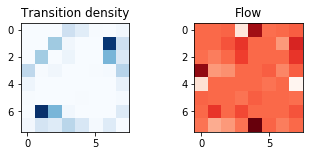

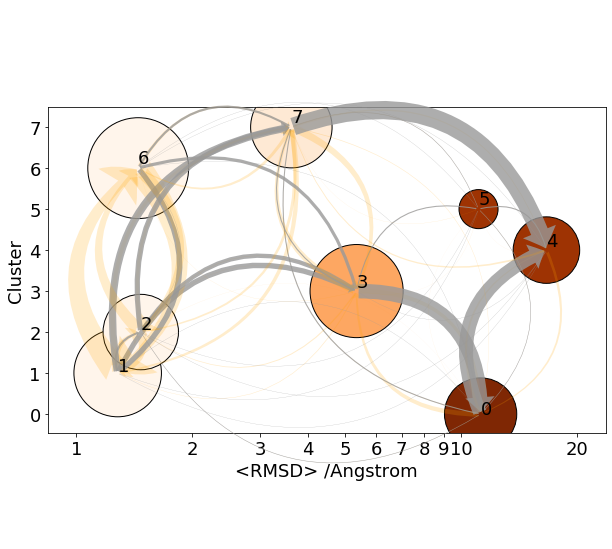

In [37]:
ligand_show =  [] 
out_name = "cluster-traj.png"
arg_Label_list = plot_graph_New(df_ext,DIR_out+out_name,ligand_show,draw_round = False, water=False)


##   4. Vizualise cluster composition

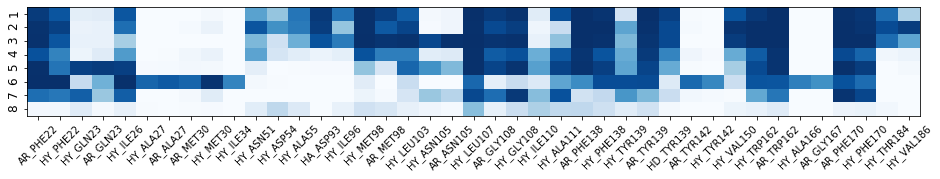

In [14]:
threshold = 0.5
sorted_labels = labels_list[arg_Label_list]

file_save = DIR_out+"cluster_traj-population-img.png"
df_ext_ligand = df_ext[df_ext.ligand.isin([ligand])]

p = []
for c in columns_IFP: p.append(c[6:])
indx = np.argsort(np.asarray(p).astype(float))  

ar = np.zeros((len(sorted_labels),indx.shape[0]), dtype = float)
for i,l in enumerate(sorted_labels):
    ar[i] = df_ext[df_ext.label == l][columns_IFP].mean().values[indx]
    
br = np.max(ar,axis=0)
indx_threshold = np.where(br > threshold)[0]
col_threshold = np.asarray(columns_IFP)[indx][indx_threshold]

fig = plt.figure(figsize = (16, int(Frame_clusters/3.1)),facecolor='w')
ax = plt.subplot(1,1,1)
plt.imshow(ar[:,indx_threshold],cmap='Blues',aspect = "auto")
plt.xticks(range(0,col_threshold.shape[0]),col_threshold ,rotation=45,fontsize=10)
plt.yticks(range(0,len(sorted_labels)),sorted_labels,rotation=90,fontsize=12)
# to put at y axis numer sequentially
#plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=12)
if file_save !="":plt.savefig(file_save,format='png', dpi=300, bbox_inches='tight',transparent=True)  
else: plt.show()


## 5. Save clasters on a 3D grid; use COM of just one ligand

In [15]:
for k in np.unique(df_ext.label.values):
    if len(ligand_show) > 0:
        df_cl = df_ext[df_ext.ligand == ligand_show[0]]
    else: df_cl = df_ext
    d_cluster = df_cl[df_cl.label == k]
    if d_cluster.shape[0] > 20:
        Map_3D_grid(d_cluster,DIR_out+"cluster-05-"+str(k)+".dx")


#  III. Cluster egress routs by the last PL contacts befor ligand dissociation

[]

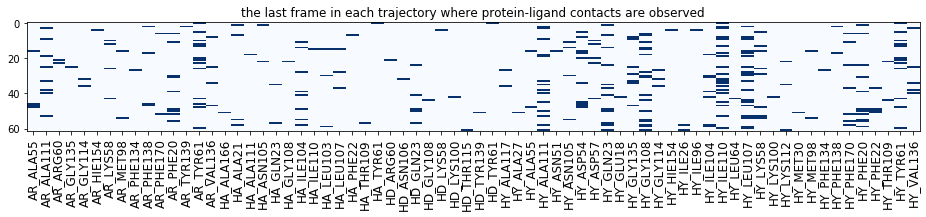

In [16]:
# ----------- make  list  IFPs 
ifp_list = ["AR","HD","HA","HY","WB","IP","IN","WB"]
columns_IFP = []  # standard IFP list
for c in df_tot.columns.tolist():
    if c[0:2] in ifp_list: columns_IFP.append(c)

#--------------- cluster by the last frame IFP
ar,r_t_f,df,com,time = last_frames_by_contact(df_tot,columns_IFP,3)
ar_nonzero = ar[:,(np.array(ar).sum(0)>0)]  # remove empty columns
columns_IFP_nonzero = np.asarray(columns_IFP)[np.argwhere((np.array(ar).sum(0)>0)).flatten()]
#---------------  plot results
fig = plt.figure(figsize = (16,2),facecolor='w')
plt.imshow(ar_nonzero.astype(float),cmap='Blues',aspect = "auto")
plt.xticks(range(0,len(columns_IFP_nonzero)),columns_IFP_nonzero,rotation=90,fontsize=12)
plt.title("the last frame in each trajectory where protein-ligand contacts are observed")
plt.plot()


In [ ]:
X = ar_nonzero.astype(float)

Z= linkage(X, metric='correlation', optimal_ordering=False)
threshold = 0.6

plt.figure(figsize=(20,3))
plt.axhline(y=threshold, c='grey', lw=1, linestyle='dashed')
hierarchy.set_link_color_palette(['r', 'b', 'orange', 'y', 'green', 'm','gray'])
den = dendrogram(Z, 0.25, color_threshold=threshold, above_threshold_color='k', leaf_font_size=9)

plt.savefig(DIR_out+"dendagram-ifp.png",dpi=300)    
 
clusters = clust.fcluster(Z,threshold, criterion='distance')

cl, count = np.unique(clusters,return_counts=True )
t_cluster = []
t_std_cluster = []
ifps_cluster = []
count_cluster = []
cl_cluster = []
for k,c in zip(cl,count):
    ind = np.argwhere(clusters==k).flatten() # trajectories in the cluster k
    ifps_mean = np.mean(X[ind,:],axis=0)
    print(k,c, columns_IFP_nonzero[np.argwhere(ifps_mean > 0)].flatten())
    if c > 1:
        tb = np.asarray(bootstrapp(time[ind]))
        if (len(tb) > 0):
            t_cluster.append(np.mean(tb)/500)
            t_std_cluster.append(np.std(tb)/500)
        else:
            t_cluster.append(0)
            t_std_cluster.append(0)
        cl_cluster.append(k)
        count_cluster.append(c)
        ifps_cluster.append(np.sum(ar_nonzero.astype(float)[ind,:],axis=0))

#t_cluster = np.asarray(t_cluster)
index = []
for a in columns_IFP_nonzero:  index.append(int(a[6:]))
index = np.argsort(index)

1 3 ['AR_GLY114' 'AR_PHE134' 'HD_ASN106' 'HY_ALA117' 'HY_GLY114' 'HY_ILE110'
 'HY_PHE134']
2 30 ['AR_ALA55' 'AR_ALA111' 'AR_ARG60' 'AR_GLY135' 'AR_LYS58' 'AR_MET98'
 'AR_PHE138' 'AR_TYR139' 'AR_TYR61' 'AR_VAL136' 'HA_TYR61' 'HD_ARG60'
 'HD_TYR61' 'HY_ALA55' 'HY_ALA111' 'HY_ASN51' 'HY_ASP54' 'HY_ASP57'
 'HY_GLY135' 'HY_ILE110' 'HY_LEU64' 'HY_LEU107' 'HY_LYS58' 'HY_MET98'
 'HY_PHE138' 'HY_TYR61' 'HY_VAL136']
3 25 ['AR_PHE170' 'AR_PHE20' 'HA_ALA21' 'HA_ALA111' 'HA_ASN105' 'HA_GLN23'
 'HA_ILE104' 'HA_ILE110' 'HA_LEU103' 'HA_LEU107' 'HA_PHE22' 'HA_THR109'
 'HD_GLN23' 'HD_GLY108' 'HD_THR115' 'HY_ALA111' 'HY_ASN105' 'HY_GLN23'
 'HY_GLY108' 'HY_ILE26' 'HY_ILE104' 'HY_LEU107' 'HY_LYS112' 'HY_PHE170'
 'HY_PHE20' 'HY_PHE22' 'HY_THR109']
4 1 ['HA_ASN105' 'HA_GLY108' 'HY_LYS112' 'HY_THR109']
5 1 ['HD_LYS100' 'HY_GLU18' 'HY_ILE104' 'HY_LYS100']
6 1 ['HA_ALA166' 'HD_TYR139' 'HY_ALA27' 'HY_MET30' 'HY_PHE22']
7 1 ['AR_HIE154' 'HD_LYS58' 'HY_HIE154' 'HY_ILE96']
['SAD_3-RA']


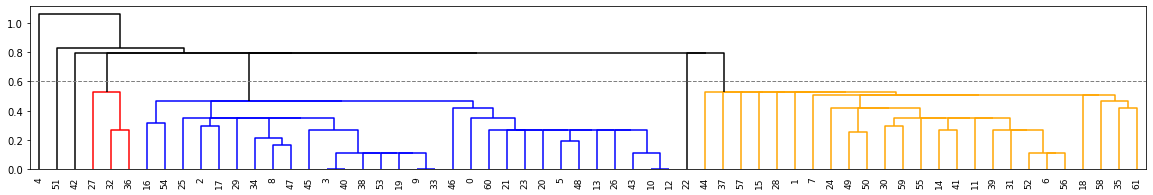

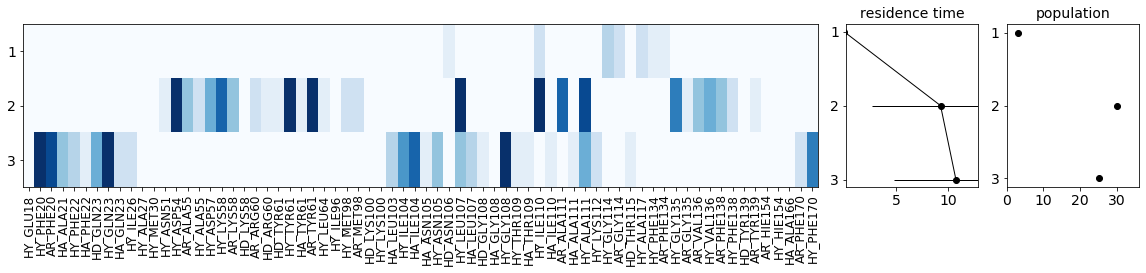

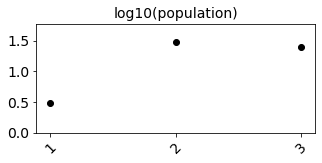

In [17]:
fig = plt.figure(figsize = (20,3),facecolor='w') 
gs = gridspec.GridSpec(1,3, width_ratios=[6, 1,1],wspace=0.08) 


ax = plt.subplot(gs[0])
ax.imshow(np.asarray(ifps_cluster)[:,index],cmap='Blues',aspect = "auto",vmin=0, vmax=10)
plt.yticks(range(0,np.asarray(ifps_cluster).shape[0]),cl,fontsize=14)
plt.xticks(range(0,len(columns_IFP_nonzero)),columns_IFP_nonzero[index],rotation=90,fontsize=12)
#---------- plot residence times in clusters
ax = plt.subplot(gs[1])
ax.errorbar(y=range(0,len(t_cluster)),x=np.flip(t_cluster),xerr=np.flip(t_std_cluster),color = 'k', marker='o',lw=1)
plt.yticks(range(0,len(cl_cluster)),np.flip(cl_cluster),fontsize=14)
plt.xlim((0.2,1.2*max(t_cluster)))
plt.xticks(fontsize=14)
plt.title("residence time",fontsize=14)
#plt.ylim((1,len(t_cluster)+1))
#--------------- plot cluster population
ax = plt.subplot(gs[2])
ax.scatter(y=range(0,len(t_cluster)),x=np.flip(count_cluster),color = 'k')
plt.yticks(range(0,np.max(cl_cluster)),np.flip(cl_cluster),fontsize=14)
plt.xticks(fontsize=14)
plt.xlim((0,1.2*np.max(count_cluster)))
plt.title("population",fontsize=14)
#plt.ylim((1,np.max(cl)))
plt.savefig(DIR_out+"clusters-ifp.png",dpi=300,bbox_inches = 'tight')    
 
    
fig = plt.figure(figsize = (5,2),facecolor='w') 
plt.scatter(y=np.log10(count_cluster),x=range(0,len(t_cluster)),color = 'k')
plt.xticks(range(0,len(cl_cluster)),cl_cluster,fontsize=14,rotation = 45)
plt.yticks(fontsize=14)
plt.ylim((0,1.2*np.max(np.log10(count_cluster))))
plt.title("log10(population)",fontsize=14)
print(df.ligand.unique())

### Mapping ligand COM in all snapshots (or only those from a particualr cluster) onto the 3D grid  and save as a file in the  .dx format

In [18]:
# 1. Save all snapshots
df_tot_to_save = df_tot # all snapshots
Map_3D_grid(df_tot_to_save,DIR_out+"density.dx")

In [19]:
# 2. Save each cluster separately
for k,c in zip(cl,count):
    ind = np.argwhere(clusters==k).flatten() # trajectories in the cluster k
    channel = np.asarray(r_t_f)[ind]
    for i,ch in enumerate(channel):
        d = df_tot[(df_tot.Repl == ch[0]) & (df_tot.Traj == ch[1])] # & (df_tot.time == int(ch[2]))]
        if i == 0: d_channel = d
        else: d_channel = pd.concat([d_channel,d])
    if(i>0):
        Map_3D_grid(d_channel,DIR_out+"density"+str(k)+".dx")